## Отчёт об экспериментальном исследовании

### Цель

* Сравнить производительность линейного алгоритма вычисления транзитивного замыкания с квадратичным

### Эксперимент

* [Датасет](https://drive.google.com/file/d/19L7RUCJlkgWQpQRnp6hMb7MLXibB4jTp/view?usp=sharing) состоит из графов и запросов, представленных регулярными выражениями над метками соответствующих графов

* Характеристики графов

| Graph | #V | #E |
|:-----:|:--:|:--:|
| LUBM300 | 358434 | 1449711 |
| geospecies | 450609 | 2201532 |
| LUBM500 | 596760 | 2416513 |
| LUBM1M | 1188340 | 4820728 |
| LUBM1.5M | 1780956 | 7228358 |
| LUBM1.9M | 2308385 | 9369511 |
| proteomes | 4834262 | 12366973 |
| uniprotkb_archea_asgard_group_1935183_0 | 6442630 | 24465430 |
| mappingbased_properties_en | 8332233 | 25346359 |

* В качестве запросов использованы регулярные выражения над метками соответствующих графов
    * Всего 280 запросов на каждый граф
    * Все запросы разбиты на 16 групп по схожести структуры

* Характеристики ЭВМ:
    * ОС Ubuntu 20.04
    * Intel core i7-4790 CPU 3.60 GHz
    * DDR3 32Gb RAM

* Описание реализации:
    * `LabeledGraph` --- реализация абстракции помеченного графа, в которой для реализации запроса достижимости с регулярными ограничениями используется алгоритм возведения матрицы транзитивного замыкания графа в квадрат
    * `LabeledGraphWithLinearTransitiveClosure` --- реализация абстракции помеченного графа, в которой для реализации запроса достижимости с регулярными ограничениями используется алгоритм линейного домножения матрицы транзитивного замыкания на матрицу смежности графа
    * `LabeledGraphWithSelectTransitiveClosure` --- реализация абстракции помеченного графа, в которой для реализации запроса достижимости с регулярными ограничениями используется алгоритм возведения матрицы транзитивного замыкания графа в квадрат, модицицированный тем, что после каждого шага алгоритма из матрицы удаляются нулевые элементы
        * В каждой реализации транзитивное замыкание вычисляется до тех пор, пока изменяется матрица транзитивного замыкания графа

* Описание замеров времени:
    * Для каждого графа один раз вычисляется время работы каждого запроса достижимости с регулярными ограничениями на трёх реализациях абстракции помеченного графа в микросекундах
    * Для более подробной визуализации результатов время из микросекунд переводится в миллисекунды
    * Для предстaвления данных и сравнения времени работы алгоритмов транзитивного замыкания через возведение в квадрат и линейного домножения матрицы транзитивного замыкания на матрицу смежности используется удобная форма графика --- `boxplot`. На нем явно видно медиану (линия внутри "коробки"), 25% и 75% квартили (сама "коробка"), 2% и 98% процентиль ("усы"), а также возможные выбросы (точки, лежащие за "усами")
    * Дополнительно, для каждого запроса вычисляется количество пар достижимостей, что сохраняется в поле `Control sum`

### Выводы

* В силу технических особенностей проведения такого рода экспериментальных исследований результаты получены для сравнительно небольшой подгруппы графов из всего датасета, что позволяет судить о поведении реализаций в весьма узком случае --- когда количество вершин в графе не превосходит 2.000.000
* Можно заметить, что, для таких небольших графов (`LUBM300`, `LUBM500`, `LUBM1M`, `LUBM1.5M`), реализация абстракции помеченного графа с использованием алгоритма возведения матрицы транзитивного замыкания в квадрат работает не намного лучше остальных двух реализаций. В среднем `LabeledGraph` и `LabeledGraphWithLinearTransitiveClosure` работают приблизительно одинаковое время
* Кроме того, можно заметить, что примененная модицикация (`LabeledGraphWithSelectTransitiveClosure`) не оправдала себя на практике. Время работы этой реализации не лучше, а в некоторых случаях даже хуже, чем времена работы первых двух реализаций
* В силу особенностей библиотеки `pygraphblas`, а именно того, что её предназначение --- работа с разряженными матрицами, необходимо сказать, что подобного рода экспериментальное исследование не является состоятельным. Так как эксперименты *только лишь над графами LUBM* --- это эксперименты над графами, чьи матрицы транзитивного замыкания более близки к плотным, чем к разряженным матрицам, что ведёт к закономерно неудачному результату
* Рекомендуется провести экспериментальное исследование на всем датасете и, дополнительно, на более разреженных графах. А также предпринять попытку реализации абстракции помеченного графа не приводящей к работе с плотными матрицами на `pygraphblas` или же применять для работы с плотными матрицами специализированные для этого средства

## Результаты для графов

In [286]:
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np

from glob import glob
from pathlib import Path
from IPython.display import display

sb.set_theme(style="ticks", palette="pastel")


def get_group_name(regex_name):
    for i in range(11, 0, -1):
        if regex_name.startswith(f'q{i}'):
            return f'q{i}'
    for i in range(12, 17):
        if regex_name.startswith(f'q_{i}'):
            return f'q{i}'


def draw_boxplot(graph, df):
    order = np.sort(df['Regex'].unique())
    bp = sb.boxplot(
        x='Regex'
        , y='Time (in milliseconds)'
        , order=order
        , hue='Implementation'
        , data=df
    )
    bp.set_title(Path(graph).stem)
    bp.set(
        xlabel='Query group'
        , ylabel='Transitive closure time in milliseconds'
    )
    plt.show()


def draw_stripplot(df):
    order = np.sort(df['Regex'].unique())
    sp = sb.stripplot(
        x='Regex'
        , y='Time (in milliseconds)'
        , order=order
        , hue='Graph'
        , data=df
    )
    sp.set_title('All times')
    sp.set(
        xlabel='Query group'
        , ylabel='Transitive closure time in milliseconds'
    )
    plt.show()


graphs = ['LUBM300.csv', 'LUBM500.csv', 'LUBM1M.csv', 'LUBM1.5M.csv']

In [287]:
for graph in graphs:
    df = pd.read_csv(graph)
    df['Time (in milliseconds)'] = df['Time (in microseconds)'] / 1e3
    df = df.drop(['Time (in microseconds)'], axis=1)
    display(df.sort_values(by=['Regex', 'Implementation']))

,Implementation,Graph,Regex,Control sum,Time (in milliseconds)
112,LabeledGraph,LUBM300,q10_2_0,7797,403.543
392,LabeledGraphWithLinearTransitiveClosure,LUBM300,q10_2_0,7797,401.007
672,LabeledGraphWithSelectTransitiveClosure,LUBM300,q10_2_0,7797,413.588
28,LabeledGraph,LUBM300,q10_2_1,438467,1318.736
308,LabeledGraphWithLinearTransitiveClosure,LUBM300,q10_2_1,438467,1313.676
...,...,...,...,...,...
512,LabeledGraphWithLinearTransitiveClosure,LUBM300,q_16_8,0,807.733
792,LabeledGraphWithSelectTransitiveClosure,LUBM300,q_16_8,0,810.007
116,LabeledGraph,LUBM300,q_16_9,0,643.629
396,LabeledGraphWithLinearTransitiveClosure,LUBM300,q_16_9,0,646.423


,Implementation,Graph,Regex,Control sum,Time (in milliseconds)
112,LabeledGraph,LUBM500,q10_2_0,12993,632.979
392,LabeledGraphWithLinearTransitiveClosure,LUBM500,q10_2_0,12993,649.453
672,LabeledGraphWithSelectTransitiveClosure,LUBM500,q10_2_0,12993,643.021
28,LabeledGraph,LUBM500,q10_2_1,731700,2261.429
308,LabeledGraphWithLinearTransitiveClosure,LUBM500,q10_2_1,731700,2319.260
...,...,...,...,...,...
512,LabeledGraphWithLinearTransitiveClosure,LUBM500,q_16_8,0,1390.488
792,LabeledGraphWithSelectTransitiveClosure,LUBM500,q_16_8,0,1441.691
116,LabeledGraph,LUBM500,q_16_9,0,1178.731
396,LabeledGraphWithLinearTransitiveClosure,LUBM500,q_16_9,0,1444.637


,Implementation,Graph,Regex,Control sum,Time (in milliseconds)
112,LabeledGraph,LUBM1M,q10_2_0,26098,1488.268
392,LabeledGraphWithLinearTransitiveClosure,LUBM1M,q10_2_0,26098,1497.357
672,LabeledGraphWithSelectTransitiveClosure,LUBM1M,q10_2_0,26098,1489.513
28,LabeledGraph,LUBM1M,q10_2_1,1454622,4314.933
308,LabeledGraphWithLinearTransitiveClosure,LUBM1M,q10_2_1,1454622,4393.034
...,...,...,...,...,...
512,LabeledGraphWithLinearTransitiveClosure,LUBM1M,q_16_8,0,2847.900
792,LabeledGraphWithSelectTransitiveClosure,LUBM1M,q_16_8,0,2818.848
116,LabeledGraph,LUBM1M,q_16_9,0,2026.865
396,LabeledGraphWithLinearTransitiveClosure,LUBM1M,q_16_9,0,2001.955


,Implementation,Graph,Regex,Control sum,Time (in milliseconds)
112,LabeledGraph,LUBM1.5M,q10_2_0,39071,2064.473
392,LabeledGraphWithLinearTransitiveClosure,LUBM1.5M,q10_2_0,39071,2098.454
672,LabeledGraphWithSelectTransitiveClosure,LUBM1.5M,q10_2_0,39071,2086.789
28,LabeledGraph,LUBM1.5M,q10_2_1,2182523,6686.249
308,LabeledGraphWithLinearTransitiveClosure,LUBM1.5M,q10_2_1,2182523,6731.880
...,...,...,...,...,...
512,LabeledGraphWithLinearTransitiveClosure,LUBM1.5M,q_16_8,0,4017.557
792,LabeledGraphWithSelectTransitiveClosure,LUBM1.5M,q_16_8,0,4031.388
116,LabeledGraph,LUBM1.5M,q_16_9,0,3022.818
396,LabeledGraphWithLinearTransitiveClosure,LUBM1.5M,q_16_9,0,3040.448


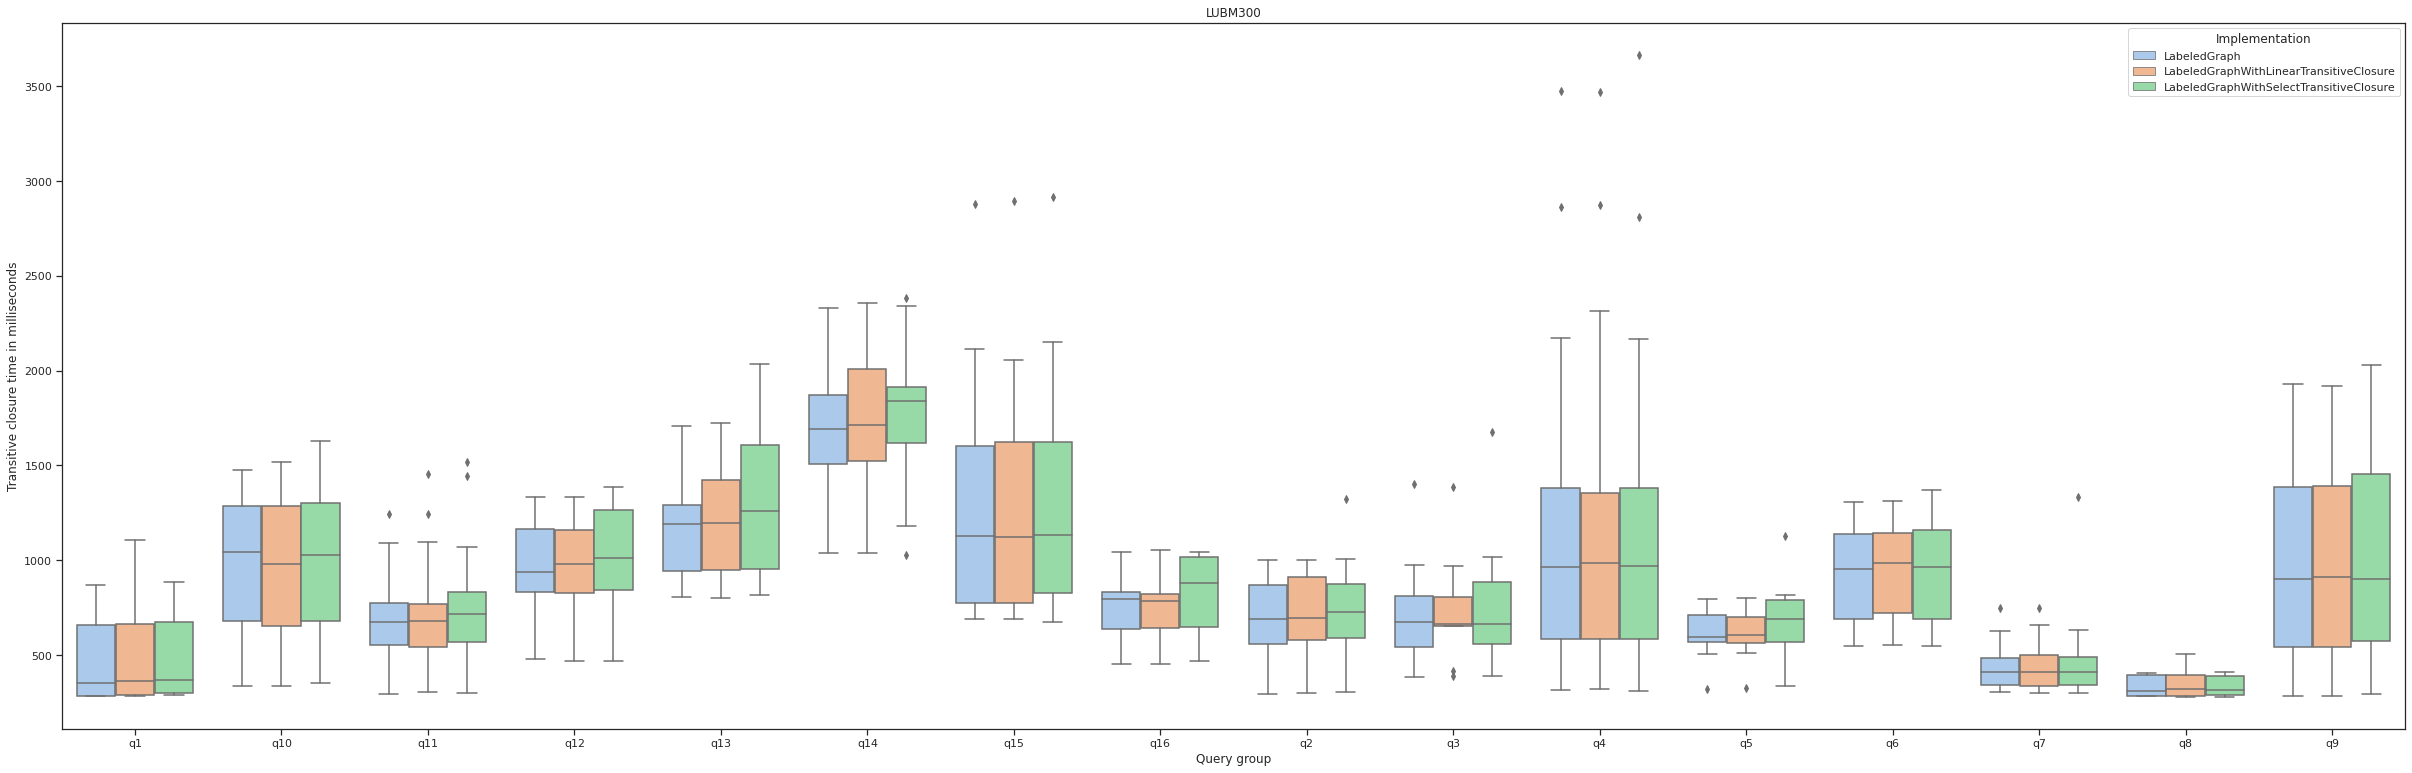

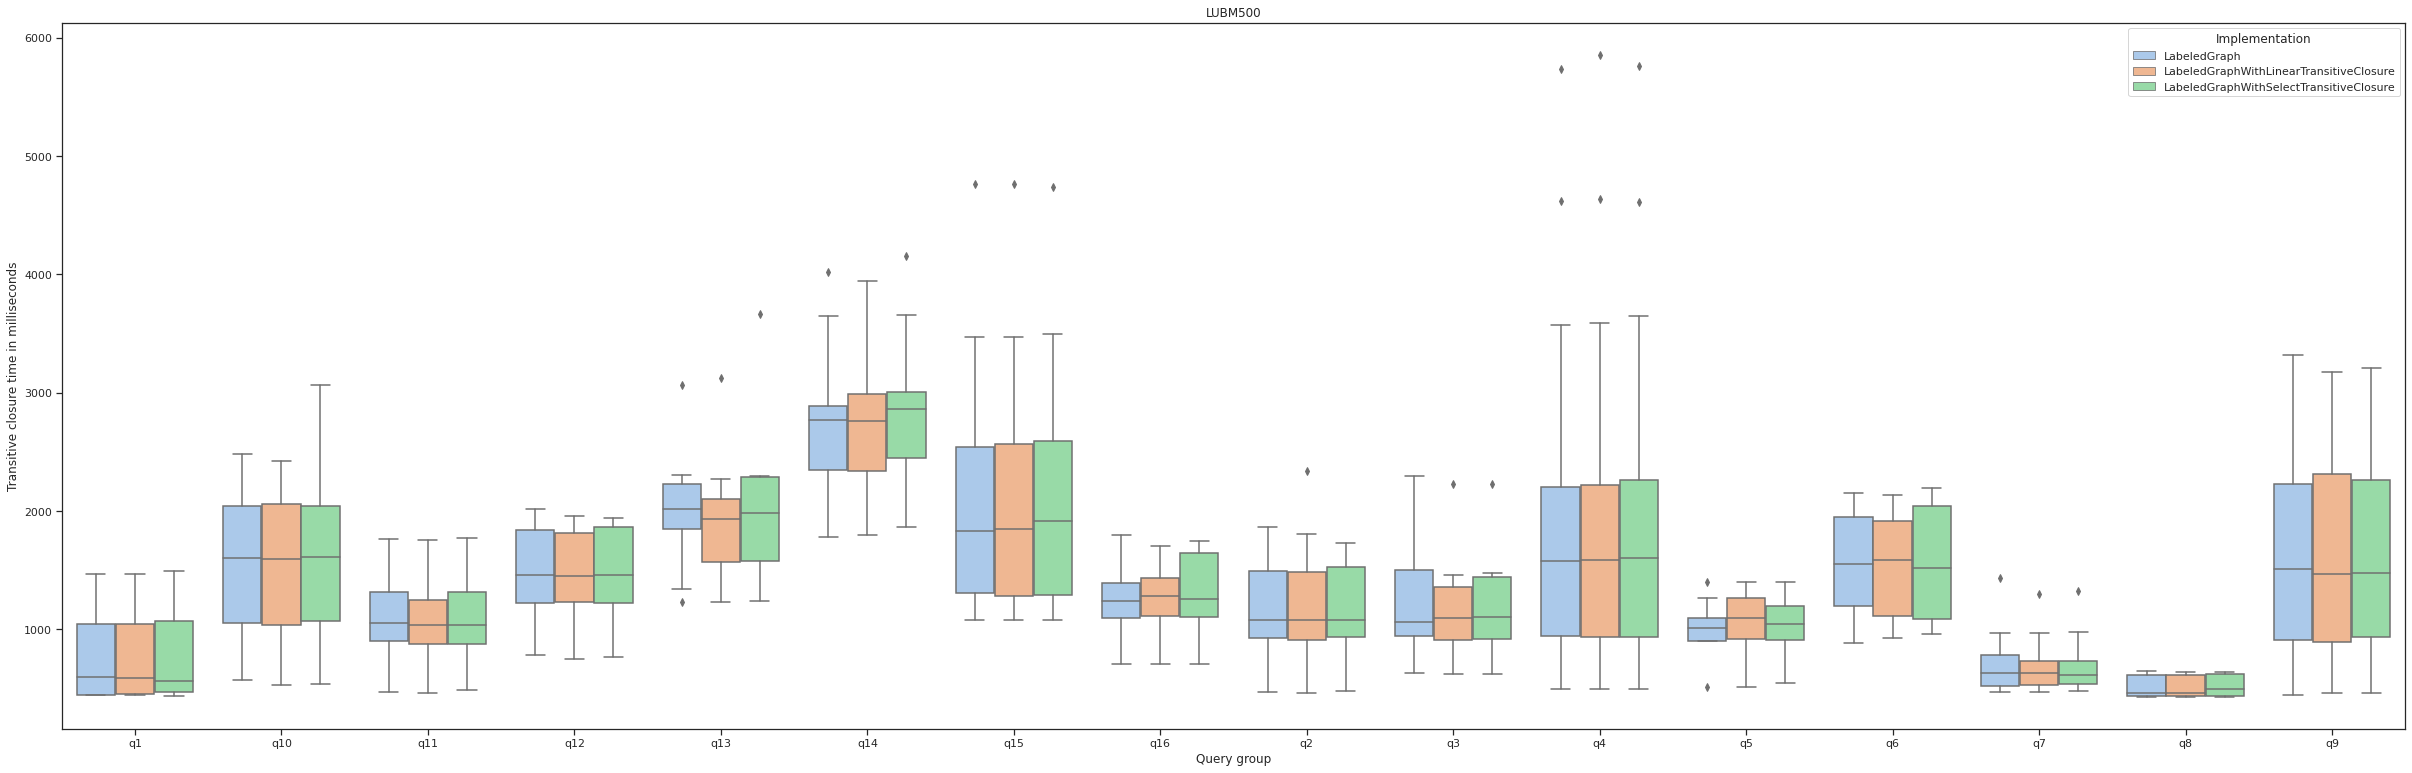

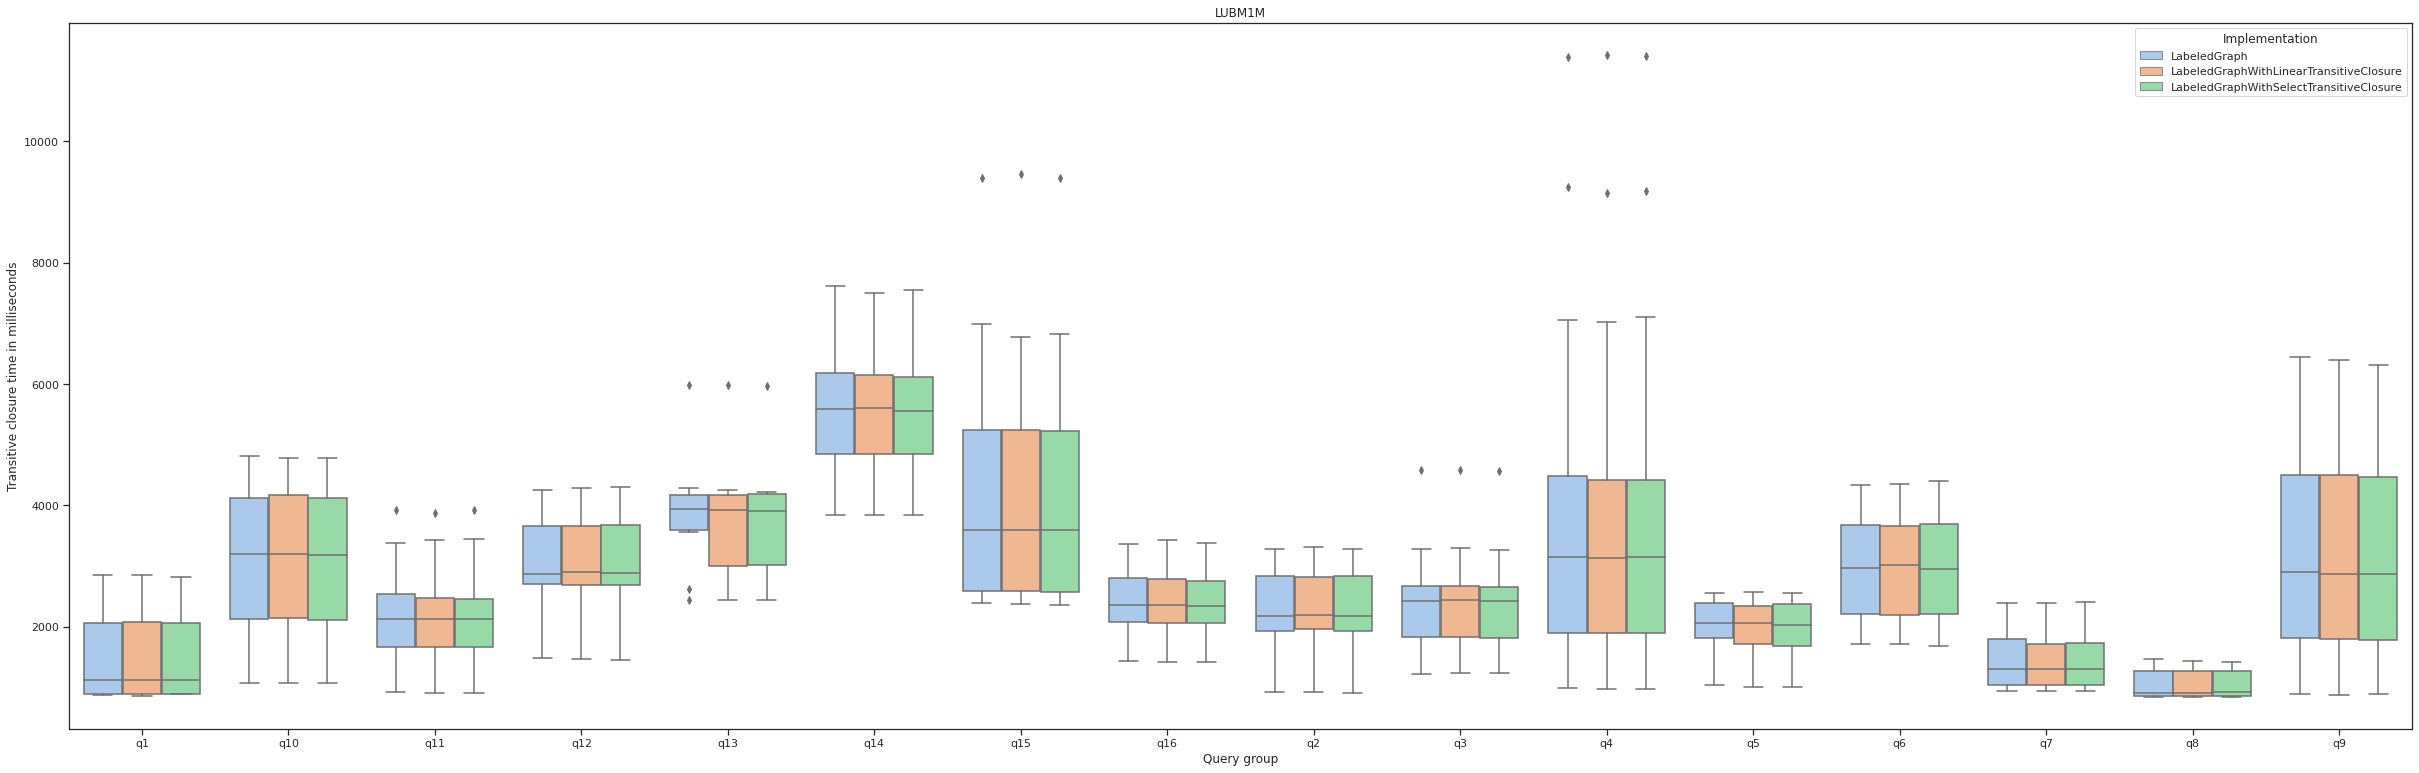

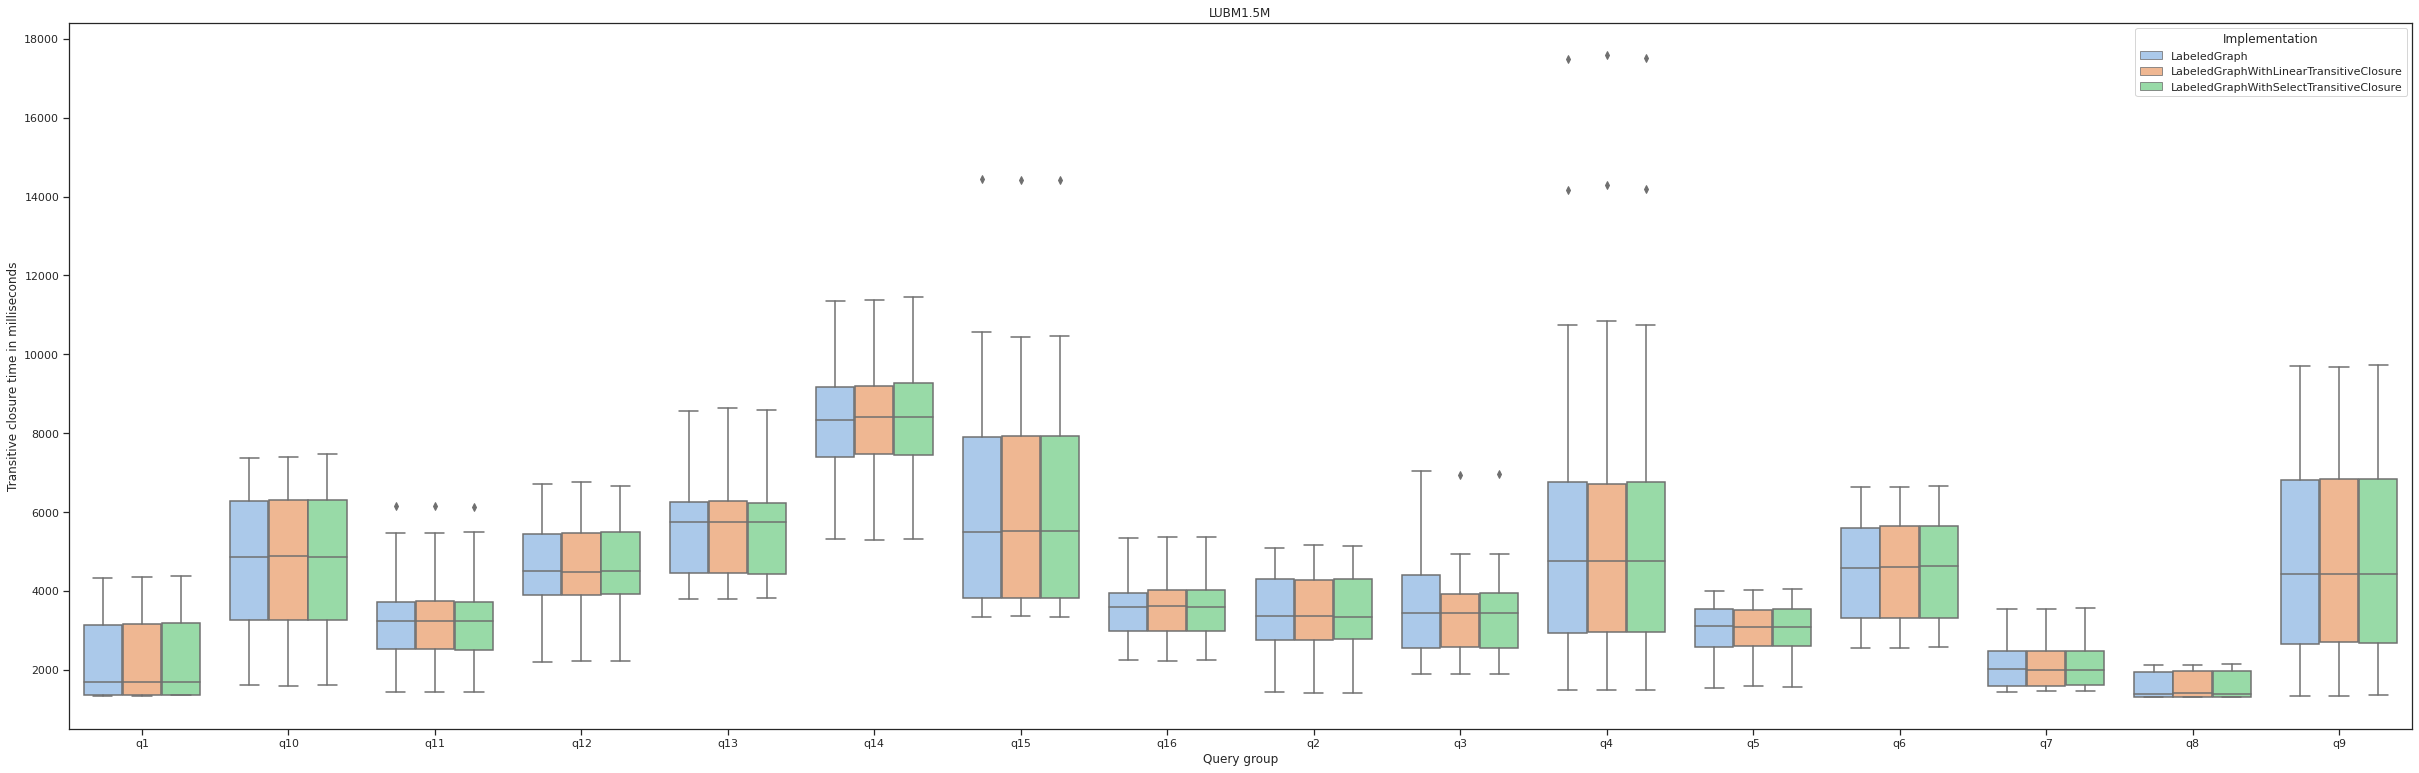

In [288]:
all_dfs = []

for graph in graphs:
    df = pd.read_csv(graph)
    df['Regex'] = df['Regex'].apply(get_group_name)
    df['Time (in milliseconds)'] = df['Time (in microseconds)'] / 1e3
    all_dfs.append(df)
    df = df.drop(['Graph', 'Time (in microseconds)'], axis=1)
    draw_boxplot(graph, df.sort_values(by=['Implementation']))

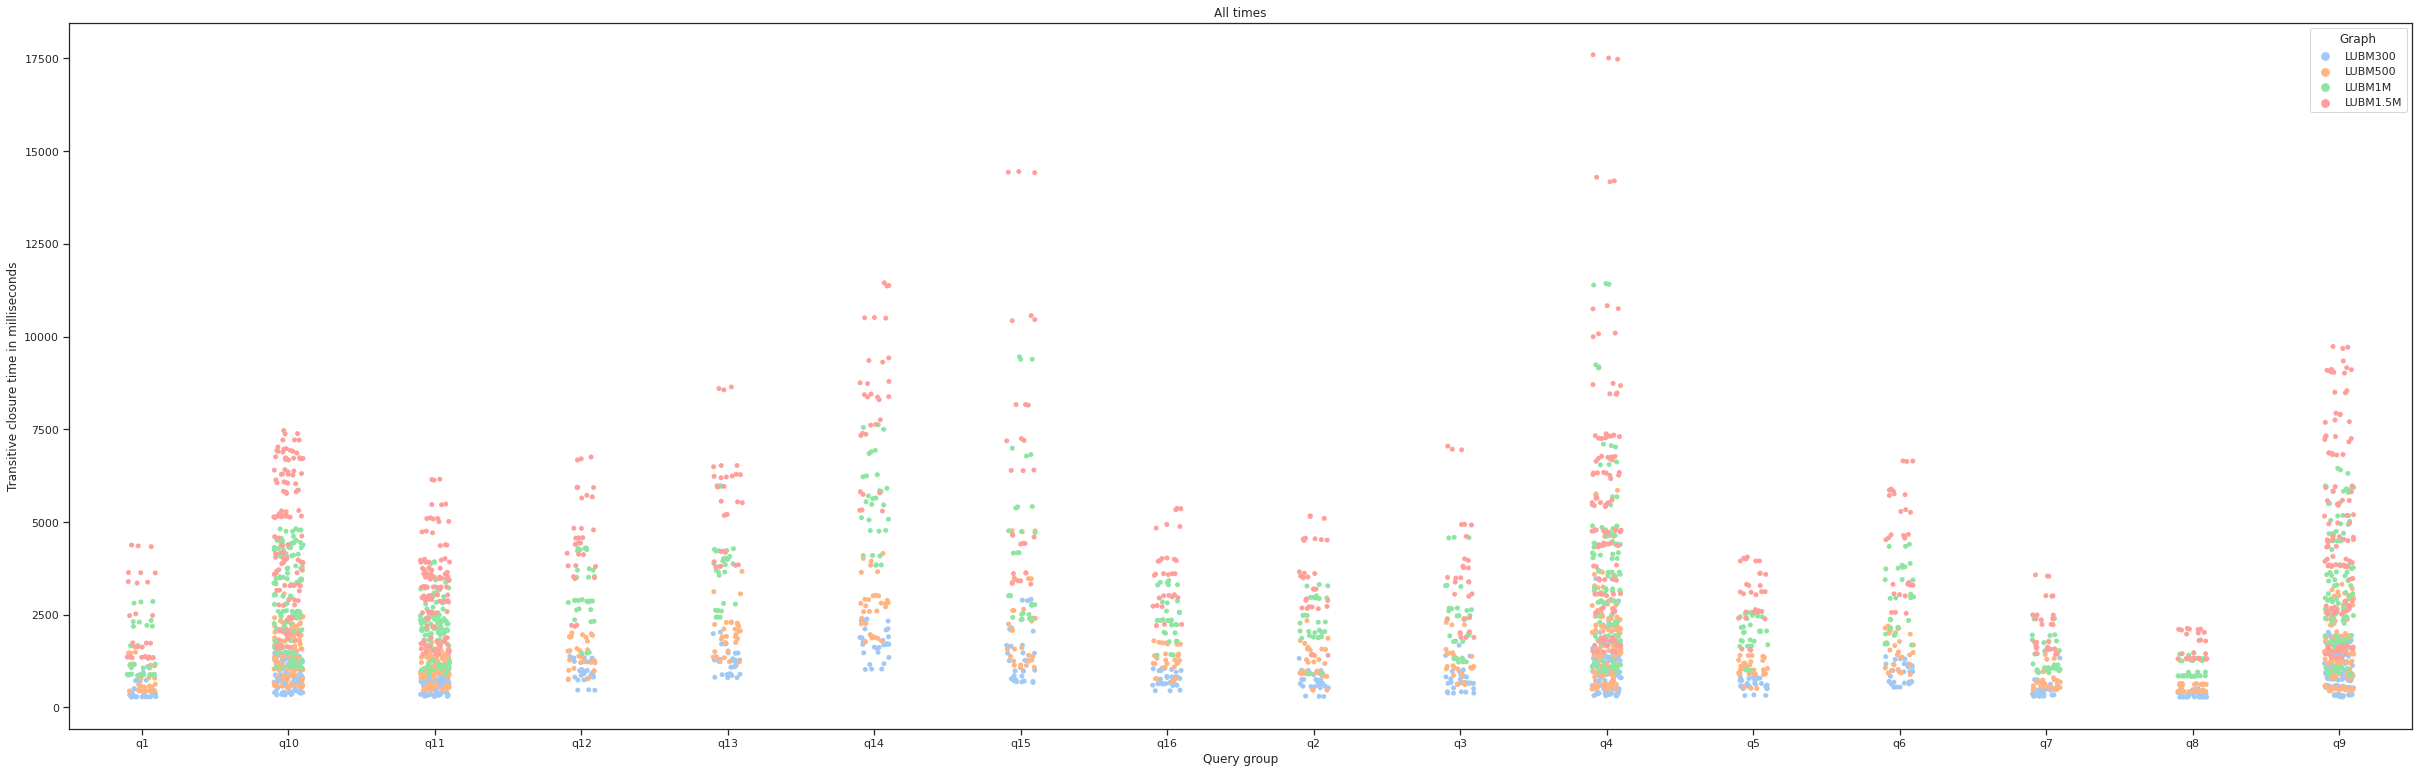

In [289]:
draw_stripplot(pd.concat(all_dfs))